In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

filepath = "./dataset/titanic/train.csv"
df_train = pd.read_csv(filepath, sep=",")
filepath = "./dataset/titanic/test.csv"
df_test = pd.read_csv(filepath, sep=",")
print(df_test)
filepath = "./dataset/titanic/gender_submission_train.csv"
df_test_su = pd.read_csv(filepath, sep=",")

     PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
0      male  34.5      0      0 

In [2]:
# 检查缺失值
print(df_train.isnull().sum())

print(df_train["Embarked"].mode()[0])
# 用中位数填充 "Age" 列的缺失值
df_train["Age"].fillna(df_train["Age"].median(), inplace=True)

# 用最频繁出现的值填充 "Embarked" 列的缺失值
df_train["Embarked"].fillna(df_train["Embarked"].mode()[0], inplace=True)

# 对于 "Cabin" 列，用 "Unknown" 填充缺失值
df_train["Cabin"] = df_train["Cabin"].fillna("Unknown")
df_train.drop(["Cabin"], axis=1, inplace=True)

# 性别转换为二进制值
df_train["Sex"] = df_train["Sex"].map({"male": 1, "female": 0})

# 对“Embarked”进行One-Hot编码，并删除第一个类别以避免多重共线性
df_train = pd.get_dummies(df_train, columns=["Embarked"], drop_first=True)

# 删除与预测任务无关的特征
df_train.drop(["Name", "Ticket", "PassengerId"], axis=1, inplace=True)


# 生成新特征，例如家庭人数
df_train["FamilySize"] = df_train["SibSp"] + df_train["Parch"] + 1

# 再次检查是否有缺失值
print(df_train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
S
Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_Q    0
Embarked_S    0
FamilySize    0
dtype: int64


In [3]:
# 检查缺失值
print(df_test.isnull().sum())

print(df_test["Embarked"].mode()[0])
# 用中位数填充 "Age" 列的缺失值
df_test["Age"].fillna(df_test["Age"].median(), inplace=True)

# 用最频繁出现的值填充 "Embarked" 列的缺失值
df_test["Embarked"].fillna(df_test["Embarked"].mode()[0], inplace=True)

# 对于 "Cabin" 列，用 "Unknown" 填充缺失值
df_test["Cabin"] = df_test["Cabin"].fillna("Unknown")
df_test.drop(["Cabin"], axis=1, inplace=True)

# 性别转换为二进制值
df_test["Sex"] = df_test["Sex"].map({"male": 1, "female": 0})

# 对“Embarked”进行One-Hot编码，并删除第一个类别以避免多重共线性
df_test = pd.get_dummies(df_test, columns=["Embarked"], drop_first=True)

# 删除与预测任务无关的特征
df_test.drop(["Name", "Ticket", "PassengerId"], axis=1, inplace=True)


# 生成新特征，例如家庭人数
df_test["FamilySize"] = df_test["SibSp"] + df_test["Parch"] + 1

# 再次检查是否有缺失值
print(df_test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
S
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          1
Embarked_Q    0
Embarked_S    0
FamilySize    0
dtype: int64


In [4]:
class mydata(Dataset):
    def __init__(self, feature, targets):
        self.x_data = torch.tensor(feature, dtype=torch.float32)
        self.y_data = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.x_data)


train_data = df_train.to_numpy()
print(train_data)

x_data = train_data[:, 1:]
y_data = train_data[:, 0]

train_data = mydata(x_data, y_data)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
print(train_loader)

test_data = df_test.to_numpy()
test_data_su = df_test_su.to_numpy()
# print(len(test_data[0]))
# print(test_data_su)
# print(test_data_su[:, 1])
x_data = test_data[:, :]
y_data = test_data_su[:, 1]
test_data = mydata(x_data, y_data)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)
print(test_loader)

[[0. 3. 1. ... 0. 1. 2.]
 [1. 1. 0. ... 0. 0. 2.]
 [1. 3. 0. ... 0. 1. 1.]
 ...
 [0. 3. 0. ... 0. 1. 4.]
 [1. 1. 1. ... 0. 0. 1.]
 [0. 3. 1. ... 1. 0. 1.]]


In [18]:
import torch.nn.functional as F


class BinaryModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BinaryModel, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 8)
        self.linear2 = torch.nn.Linear(8, 4)
        self.linear3 = torch.nn.Linear(4, 1)

    def forward(self, x):
        out = F.relu(self.linear1(x))
        out = F.relu(self.linear2(out))
        out = torch.sigmoid(self.linear3(out))  # 仅在最后一层使用Sigmoid
        return out


input_dim = len(x_data[0])
output_dim = 1
print(input_dim, output_dim)

model = BinaryModel(input_dim, output_dim)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10001
loss_list = []
accurancy_list = []

for epoch in range(epochs):
    loss_sum = 0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, targets = data
        y_pred = model(inputs)

        loss = criterion(y_pred, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    if batch_idx % 27 == 0 and epoch % 50 == 0:
        # print(
        #     f"epoch : {epoch} : batch_idx : {batch_idx}, loss_sum {loss_sum/len(train_loader)}"
        # )
        loss_list.append(loss_sum / len(train_loader))
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, targets = data
                outputs = model(inputs)

                predicted = outputs.round()  # 四舍五入到0或1
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
        accurancy_list.append(accuracy)
        print(
            f"Epoch: {epoch}, Loss: {loss_sum / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%"
        )

9 1
Epoch: 0, Loss: 0.7217, Accuracy: 64.59%
Epoch: 50, Loss: 0.5767, Accuracy: 66.75%
Epoch: 100, Loss: 0.5572, Accuracy: 70.57%
Epoch: 150, Loss: 0.5224, Accuracy: 70.10%
Epoch: 200, Loss: 0.4944, Accuracy: 67.22%
Epoch: 250, Loss: 0.5070, Accuracy: 83.25%
Epoch: 300, Loss: 0.4801, Accuracy: 84.45%
Epoch: 350, Loss: 0.4667, Accuracy: 89.23%
Epoch: 400, Loss: 0.4592, Accuracy: 83.01%
Epoch: 450, Loss: 0.4515, Accuracy: 72.73%
Epoch: 500, Loss: 0.4380, Accuracy: 88.76%
Epoch: 550, Loss: 0.4595, Accuracy: 90.43%
Epoch: 600, Loss: 0.4429, Accuracy: 88.04%
Epoch: 650, Loss: 0.4381, Accuracy: 88.76%
Epoch: 700, Loss: 0.4367, Accuracy: 87.32%
Epoch: 750, Loss: 0.4377, Accuracy: 84.69%
Epoch: 800, Loss: 0.4200, Accuracy: 75.60%
Epoch: 850, Loss: 0.4354, Accuracy: 89.00%
Epoch: 900, Loss: 0.4350, Accuracy: 89.95%
Epoch: 950, Loss: 0.4300, Accuracy: 86.84%
Epoch: 1000, Loss: 0.4294, Accuracy: 89.47%
Epoch: 1050, Loss: 0.4208, Accuracy: 87.80%
Epoch: 1100, Loss: 0.4224, Accuracy: 85.65%
Epoch: 

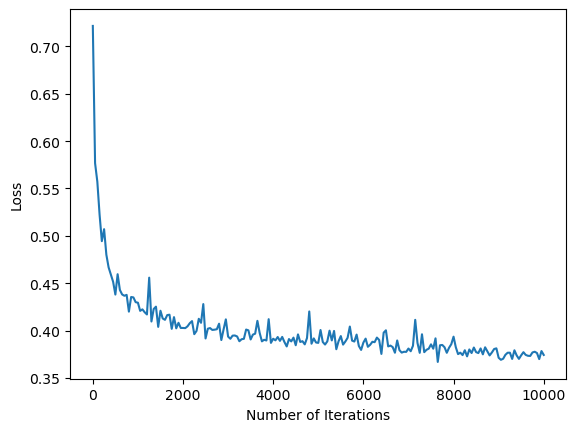

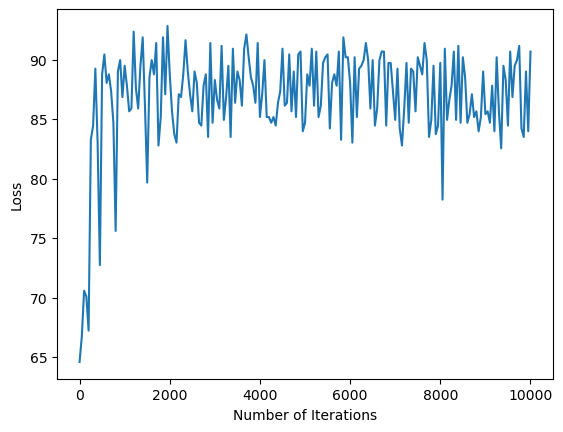

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(0, 10001, 50), loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()
plt.plot(range(0, 10001, 50), accurancy_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()